<a href="https://colab.research.google.com/github/GregSym/Numberphile_Follow_Alongs/blob/spoon/NumberphileRundowns_WitnessNumbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Numberphile Follow-Along Maths</h1>

Here follow some selected numberphile math reviews

# Witness Numbers (and the truthful 1,662,803) - Numberphile
## Nov 28, 2021

https://www.youtube.com/watch?v=_MscGSN5J6o

<h3>here's a pythonic breakdown of the intro to the video:</h3>

(Matt Parker does sort of gloss over the recursive algorithm he's using, but it's easier in real maths than in a program so we'll forgive him that)

In [54]:
from __future__ import annotations  # alt for typing import, allows 3.9^ typing

n: int = 747  # number to test
a: int = 23  # witness number

# test rules
assert n > 2 and n%2 == 1  # odd n greater than 2

def recursive_coeffecient_calculation(n_minus_1: int, m: int=1) -> tuple[int, int]:
  """ Recursively determine the coefficient d in the equation: n = 2**m * d + 1 """
  d_float: float = n_minus_1 / 2  # note: python will treat this as a float, typing aside
  assert d_float.is_integer()  # ensure int and then convert
  d: int = int(d_float)
  if d%2 == 0:
    m += 1
    d, m = recursive_coeffecient_calculation(n_minus_1=d, m=m)
  return d, m
  


d, m = recursive_coeffecient_calculation(n_minus_1=n - 1)

rearrangement = (2 ** m) * d + 1
rearrangement

747

The next step is the test a^d == 1 mod n

In [55]:
(a**d)%n  # plugging large floats into d here will overflow, hence the conversion above


131

With the final Witness Test looking like this:

In [56]:
if (a**d)%n == 1 or (a**d)%n == -1 or (a**d)%n == n - 1:  # I don't think mod ever returns -1 in python, this is just included as an explainer for the third clause
  print(True)
else:
  print(False)

False


Note: a false is 100% reliable, a True is not (True here meaning n is prime)

Per Matt Parker: "They're called strong liars"

### Naive Implementation

They then demonstrate a liar (10) in action on n of 91 - so I'm going to write out a naive implementation of a witness test function without multiple witnesses

probably worth including the algorithm as implemented on Wikipedia here, because
they don't go into super deep detail on how higher values of m are handled in the numberphile video: https://en.wikipedia.org/wiki/Miller%E2%80%93Rabin_primality_test
```
Input #1: n > 3, an odd integer to be tested for primality
Input #2: k, the number of rounds of testing to perform
Output: “composite” if n is found to be composite, “probably prime” otherwise

write n as 2^r·d + 1 with d odd (by factoring out powers of 2 from n − 1)
WitnessLoop: repeat k times:
    pick a random integer a in the range [2, n − 2]
    x ← a^d mod n
    if x = 1 or x = n − 1 then
        continue WitnessLoop
    repeat r − 1 times:
        x ← x^2 mod n
        if x = n − 1 then
            continue WitnessLoop
    return “composite”
return “probably prime”
```
note: I the loop is doing the thing where it checks every number for n - 2 and returning a probabilistic primeness, the below function is concerned only with the inside of the WitnessLoop, but it references it in the continue statements, so I'm including the whole thing here, for full context.

In [57]:
def naive_witness_test(n: int, a: int, verbose: bool = False) -> bool:
  """ A naive implementation of a witness test that simply uses one witness 
    - returns True if prime, false if not
    - remember, they're 'strong liars', so only False is certain
  """
  # check rules
  assert n > 2 and n%2 == 1  # odd n greater than 2
  d, m = recursive_coeffecient_calculation(n_minus_1=n - 1)
  if verbose:
    print(d, m)

  # check accuracy of rearrangement
  # this sort of thing would go in a test file if packaged
  assert n == (2 ** m) * d + 1, f"fails fundamental equality, {n} != {(2 ** m) * d + 1}, m: {m}, d: {d}, witness or a: {a}"  
  assert a <= n - 2, f"failed check: {a} <= {n}-2 - witness number, a, must be less than the number under inspection, n"
  ask_witness = (a**d)%n
  if verbose:
    print(f"starting witness check: {ask_witness}")
  
  # basic case
  if ask_witness == 1 or ask_witness == n - 1:
      return True
  
  # higher exponent case (denoted as r for 1 < r < m)
  ask_witness_generator = ((a**((2**new_exponent)*d))%n for new_exponent in range(1, m))  # generate other witnesses for larger m
  for ask_witness in ask_witness_generator:
    if verbose:
      print(ask_witness)
    if ask_witness == n - 1:
      return True
  
  return False

In [58]:
print(naive_witness_test(n=747, a=23))
print(naive_witness_test(n=5, a=3))
print(naive_witness_test(n=7, a=3))
print(naive_witness_test(n=13, a=3))
print(naive_witness_test(n=17, a=3))
print(naive_witness_test(n=1729, a=3))  # expect false
naive_witness_test(n=91, a=10)

False
True
True
True
True
False


True

In [59]:
3**((2**3)*1)%17

16

### Star Witnesses / Miller Rabin Test

You can use reliable star witnesses to implement a prime checker that works for 
certain values of n

In [60]:
from typing_extensions import Protocol  # < 3.8 Protocol lives in a different package 

class StarWitnessesInterface(Protocol):
  """ An interface for interacting with defined 
      test cases for the Miller Rabin Test 
  """
  @property
  def star_witnesses(self) -> tuple[int, ...]:...
  @property
  def upper_bound(self) -> int:...

smallest_possible = (2, 3)  # works for: 1_373_653
three_numbers = (2, 3, 5)  # works for 25_326_001
bigger_list_of_two = (31, 73)  # 9_080_191
squad_of_four = (2, 13, 23, 1_662_803)  # 1_122_004_669_633
friendly_five = (2, 3, 5, 7, 11)  # 2_152_302_898_747 ...oh, look, Matt's bow
twelve_angry_men = (2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37)  # 10^23
# 318_665_857_834_031_151_167_461  --might not go in a regular int by my reckoning

Because I want the star witness numbers to be defined in a constant datastructure and not subject to variable parameters, I've made an interface above and will now define constant classes for each of the above cases

In [61]:
class SmallestPossible:
  @property
  def star_witnesses(self) -> tuple[int, ...]:
    return (2, 3)
  @property
  def upper_bound(self) -> int:
    return 1_373_653

class ThreeWitnesses:
  @property
  def star_witnesses(self) -> tuple[int, ...]:
    return (2, 3, 5)
  @property
  def upper_bound(self) -> int:
    return 25_326_001

class BiggerListOfTwo:
  @property
  def star_witnesses(self) -> tuple[int, ...]:
    return bigger_list_of_two
  @property
  def upper_bound(self) -> int:
    return 9_080_191

class SquadOfFour:
  @property
  def star_witnesses(self) -> tuple[int, ...]:
    return squad_of_four
  @property
  def upper_bound(self) -> int:
    return 1_122_004_669_633
  
class FriendlyFive:
  @property
  def star_witnesses(self) -> tuple[int, ...]:
    return friendly_five
  @property
  def upper_bound(self) -> int:
    return 2_152_302_898_747

class TwelveAngryMen:
  @property
  def star_witnesses(self) -> tuple[int, ...]:
    return twelve_angry_men
  @property
  def upper_bound(self) -> int:
    return 318_665_857_834_031_151_167_461

Well, that was probably too much code for the problem at hand, wasn't it? Anyway, from now on, I use them as below and hopefully it's worth it (spoilers: nah)

In [62]:
list_of_witness_parameters: list[StarWitnessesInterface] = [
                                                            SmallestPossible(),
                                                            BiggerListOfTwo(),
                                                            ThreeWitnesses(),
                                                            SquadOfFour(),
                                                            FriendlyFive(),
                                                            TwelveAngryMen()
]

[witness_group.upper_bound for witness_group in list_of_witness_parameters]

[1373653,
 9080191,
 25326001,
 1122004669633,
 2152302898747,
 318665857834031151167461]

### We're going to need a working prime generator to run tests against quickly

now, I could do that myself. But what I'm actually going to do is use stack overflow: https://stackoverflow.com/questions/567222/simple-prime-number-generator-in-python (the code segment contains its own references that I'm leaving in)

In [63]:
# Sieve of Eratosthenes
# Code by David Eppstein, UC Irvine, 28 Feb 2002
# http://code.activestate.com/recipes/117119/

def gen_primes():
    """ Generate an infinite sequence of prime numbers.
    """
    # Maps composites to primes witnessing their compositeness.
    # This is memory efficient, as the sieve is not "run forward"
    # indefinitely, but only as long as required by the current
    # number being tested.
    #
    D = {}
    
    # The running integer that's checked for primeness
    q = 2
    
    while True:
        if q not in D:
            # q is a new prime.
            # Yield it and mark its first multiple that isn't
            # already marked in previous iterations
            # 
            yield q
            D[q * q] = [q]
        else:
            # q is composite. D[q] is the list of primes that
            # divide it. Since we've reached q, we no longer
            # need it in the map, but we'll mark the next 
            # multiples of its witnesses to prepare for larger
            # numbers
            # 
            for p in D[q]:
                D.setdefault(p + q, []).append(p)
            del D[q]
        
        q += 1

primes = gen_primes()
[next(primes) for _ in range(10)]

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

Define prime detection test

In [64]:
odd_generator = lambda lower_bound, upper_bound: (x for x in range(lower_bound, upper_bound) if x % 2)  # we're gonna want an odd num generator for testing

class _PrimeDetectorInterface(Protocol):
  def prime_determination(self, 
                          n: int, 
                          witness_group: StarWitnessesInterface = SmallestPossible()
                          ) -> bool:... 

def test_prime_detection(prime_checker: _PrimeDetectorInterface, test_start: int = 4, test_range: int = 100, verbose: bool = False):
  primes_gen = gen_primes()
  primes = [next(primes_gen) for _ in range(test_range)]
  if verbose:
    print(primes)
    [print(odd_num, prime_checker.prime_determination(n=odd_num)) for odd_num in odd_generator(test_start, test_range)]
  number_result_zipped = ((odd_num, prime_checker.prime_determination(n=odd_num)) for odd_num in odd_generator(test_start, test_range))
  for number, result in number_result_zipped:
    if result:
      assert number in primes, f"A number, {number}, was declared prime that cannot be found in test primes"
    elif not result:
      assert number not in primes, f"A number, {number},  was declared composite that can be found in test primes"

def test_individual_prime_detection(prime_checker: _PrimeDetectorInterface, n: int):
  """ lighter weight, individual prime test """
  from sympy import isprime
  print(f"sympy solution: {isprime(n)}, submitted prime checker's solution: {prime_checker.prime_determination(n)}")
  assert isprime(n) == prime_checker.prime_determination(n), "failed to match sympy implementation's prime check"



In [65]:
class PrimeDetector:
  witness_groups: list[StarWitnessesInterface] = list_of_witness_parameters  # let's just borrow that from above

  miller_rabin_rule: Callable[...] = lambda self, n: n > 2 and n%2 == 1

  def witness_group_factory(self, n: int) -> StarWitnessesInterface:
    """ factory for returning appropriate witness groups """
    for witness_group in self.witness_groups:
      if n < witness_group.upper_bound:
        return witness_group  

  def prime_determination(self, 
                          n: int, 
                          witness_group: StarWitnessesInterface = SmallestPossible()
                          ) -> bool:
    assert self.miller_rabin_rule(n), f"number must be greater than 2 and odd - number found {n}"
    
    if n >= witness_group.upper_bound: # assign an appropriate, larger witness group if necessary
      witness_group = self.witness_group_factory(n=n)
    
    # print([naive_witness_test(n=n, a=witness_number) for witness_number in witness_group.star_witnesses])
    return all([naive_witness_test(n=n, a=witness_number) for witness_number in witness_group.star_witnesses])

test_prime_detection(prime_checker=PrimeDetector(), test_range=10_000)

In [66]:
from sympy import isprime

class PrimeDetectorSympy:
  """ Wraps sympy prime verification to match interface so it can plug in as an alternative checker
      when mine gets too slow at higher ranges
  """
  def prime_determination(self, 
                          n: int, 
                          witness_group: StarWitnessesInterface = SmallestPossible()
                          ) -> bool:
    return isprime(n)

Let's do some quick edge cases in case (read: because I did) I messed up above

In [67]:
edge_cases = [1373653,
              9080191,
              25326001]
              # 1122004669633,
              # 2152302898747]
              # 318665857834031151167461]  # the uppder bounds of each witness group

# note: I'm leaving out the big bois because this runs for long enough as is - I did
# check it exactly once, it seems to work, maybe, does crash if you run on google colab tho

[test_individual_prime_detection(prime_checker=PrimeDetector(), n=test_case) for test_case in edge_cases]

other_random_cases = [13, 15, 17, 19, 21]

[test_individual_prime_detection(prime_checker=PrimeDetector(), n=test_case) for test_case in other_random_cases]

sympy solution: False, submitted prime checker's solution: False
sympy solution: False, submitted prime checker's solution: False
sympy solution: False, submitted prime checker's solution: False
sympy solution: True, submitted prime checker's solution: True
sympy solution: False, submitted prime checker's solution: False
sympy solution: True, submitted prime checker's solution: True
sympy solution: True, submitted prime checker's solution: True
sympy solution: False, submitted prime checker's solution: False


[None, None, None, None, None]

### Matt's Liar Score test

As part of the video Matt challenges viewers to calculate the numbers most frequently found to lie in the Miller Rabin Test, as a sort of inverse to the star witnesses concept.

Here's an implementation of that below which uses the Miller Rabin Test above to make the calculations

In [68]:
def liar_test_individual(prime_checker: _PrimeCheckerImplementation, n: int, witness: int) -> bool:
  """ False -> Liar, True -> Truthful """
  return naive_witness_test(n=n, a=witness) == prime_checker.prime_determination(n=n)

def liar_test(prime_checker: _PrimeCheckerImplementation, start: int=4, end: int=1000) -> dict[int, int]:
  """ -> a map of each number to the number of 
      times it lies in the Miller Rabin Test 
  """
  odd_numbers= odd_generator(start, end)
  liar_test_results: dict[int, int] = {}
  for valid_n in odd_numbers:
    all_valid_a = (x for x in range(2, valid_n - 1))  # generate valid numbers
    for a in all_valid_a:
      if not liar_test_individual(prime_checker=prime_checker, n=valid_n, witness=a):
        if liar_test_results.get(a) is None:
          liar_test_results[a] = 1
        liar_test_results[a] += 1
  
  return liar_test_results

In [69]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook  # so, %matplotlib widget fails in colab??
# anyway, this is my backup for an interactive plot

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

     0
3    3
4    2
5    2
6    3
7    4
..  ..
899  2
900  2
901  2
903  2
925  2

[585 rows x 1 columns]


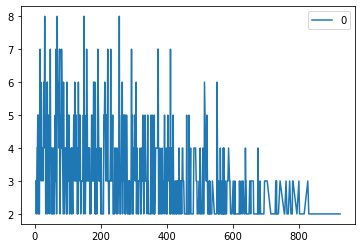

In [70]:
import pandas as pd

def visualise_liar_test():
  dict_data = liar_test(prime_checker=PrimeDetector())
  sorted_data = {k: dict_data[k] for k in sorted(dict_data)}  # sort because that's not a defaul
  df = pd.DataFrame.from_dict(sorted_data, orient='index')
  df.plot()
  f = figure()
  # add a circle renderer with a size, color, and alpha (values from bokeh docs)
  f.circle([key for key in sorted_data.keys()], [value for value in sorted_data.values()], size=20, color="navy", alpha=0.5)
  f.line([key for key in sorted_data.keys()], [value for value in sorted_data.values()], line_width=2)
  print(df)
  show(f)

visualise_liar_test()

Let's define some visualisation interfaces before we wrap this all up in a cool bow

In [71]:
class _VisualisationInterface(Protocol):
  def __call__(map_of_liars_to_count: dict[int, int], verbose: bool=False) -> None:...
  """ defines the function that takes the sorted dict object and visualises the data """

def PandasVisualisation(map_of_liars_to_count: dict[int, int], verbose: bool=False) -> None:
  df = pd.DataFrame.from_dict(map_of_liars_to_count, orient='index')
  if verbose:
    print(df)
  df.plot()

def BokehVisualisation(map_of_liars_to_count: dict[int, int], verbose: bool=False) -> None:
  f = figure()
  # add a circle renderer with a size, color, and alpha (values from bokeh docs)
  f.circle([key for key in map_of_liars_to_count.keys()], [value for value in map_of_liars_to_count.values()], size=20, color="navy", alpha=0.5)
  f.line([key for key in map_of_liars_to_count.keys()], [value for value in map_of_liars_to_count.values()], line_width=2)
  if verbose:
    print(map_of_liars_to_count)
  show(f)


Now let's build the object that runs these liar tests

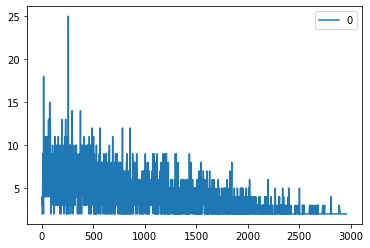

In [73]:
class LiarTestRunner:
  def __init__(self, end: int=3_000):
    self.end = end
    unsorted_dict = liar_test(prime_checker=PrimeDetectorSympy(), end=self.end)
    self.liar_data = {k: unsorted_dict[k] for k in sorted(unsorted_dict)}
  
  def visualise_liars(self, visualiser: _VisualisationInterface):
    visualiser(map_of_liars_to_count=self.liar_data)

runner = LiarTestRunner()
runner.visualise_liars(visualiser=PandasVisualisation)